<a href="https://colab.research.google.com/github/JinglunJiang/algorithms/blob/main/HW2_Primality_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Important: Use File -> Save a Copy in Drive to create a copy of this document. Edit *your copy* of the file. If you attempt to edit this file, your changes will not be saved.

# Primality Testing

In this notebook you will test different primality testing algorithms in terms of their success and running time. First you should use Eratosthenes' sieve to acquire all primes under 10,000.

In [10]:
# Imports
import math
import random
from datetime import datetime
import numpy as np

N = 10000

In [11]:
def sieve(n: int):
    is_prime = np.ones(n + 1, dtype=bool)
    # TODO: Set is_prime[0] and is_prime[1] to False
    # Then iterate over all elements and if it is True (meaning a prime)
    # mark all its multiples as False
    is_prime[0:2] = False
    primes = []
    for num in range(2, int(n**0.5) + 1):
        if is_prime[num]:
            primes.append(num)
            is_prime[num * 2:n + 1:num] = False
    for num in range(int(n**0.5) + 1, n + 1):
        if is_prime[num]:
            primes.append(num)
    return set(primes)

primes = sieve(N)
print(len(primes))

1229


Write the Fermat primality test

In [12]:
def fermat_is_prime(p: int, base=None):
    if p == 2: return True
    if base is None:
        while True:
            base = random.randint(2, p)
            if math.gcd(p, base) == 1:
                break
    # TODO: Compute (base)^(p-1) % p. Consider using the `pow` built-in function.
    # If the result is 1, return True
    # Otherwise, return False
    # Make sure that you don't use numbers significantly bigger than `p`
    if pow(base, p - 1, p) == 1:
        return True
    return False

Using a single or even a random base might not always work: $2^{340} \equiv 1\ (mod\ 341)$, but $341 = 11 \cdot 31$ is composite. These numbers are called *pseudoprimes*. There is a proof that for every composite number where the algorithm succeeds for at least one base, it will succeed for at least half of the bases. Write the repeated fermat primality test that answers the primality question correctly with probability $1 - \delta$. In order to achieve that, you will call `fermat_is_prime` iteratively until the failure probability is less than $\delta$.

In [13]:
def boosted_fermat(p: int, delta=1e-6):
    trust = 1
    while trust > delta:
        # TODO: Use the fermat primality testing multiple times to avoid pseudoprimes
        if not fermat_is_prime(p):
            return False
        trust = trust / 2
    return True

There exist certain numbers that have **no** (non coprime) bases for which the fermat test works. Those are called [Carmichael numbers](https://en.wikipedia.org/wiki/Carmichael_number). Use your primality testing with $\delta = 10^{-6}$ to print all Carmichael numbers.

In [14]:
for p in range(2, N+1):
    # TODO: Find all the Carmichael numbers
    if boosted_fermat(p) and p not in primes:
        print(p)

561
1105
1729
2465
2821
6601
8911


## Generating Primes for cryptographic use

In the [public key](https://en.wikipedia.org/wiki/Public-key_cryptography) cryptosystem [RSA](https://en.wikipedia.org/wiki/RSA_(cryptosystem)), creating a new key requires finding large primes up to thousands of bits long. The way to produce such a number is quite simple:

1. Produce a large integer
2. Check if it is prime
3. Repeat until success

It is known that the number of primes grows in a rate of $\Omega(1 / \log n)$, so generating a prime will take on average tries proporional to the bit length.

In [15]:
def generate_prime(bits, verbose = False):
    start = datetime.now()

    i = 0
    while True:
        i += 1
        if verbose and i % 10 == 0:
            print(f'\rAttempting try {i:5d}. Elapsed time: {(datetime.now() - start).total_seconds():8.2f}s', end='')
        # TODO: Generate a number in [ 2**(bits-1), 2**(bits) )
        p = random.randint(2**(bits-1), 2**(bits) - 1)
        if boosted_fermat(p):   # TODO: Check if it is prime using the boosted fermat test you
            if verbose:
                print()  # Prevent the next line from overwriting the previous (see \r carriage return)
            return p, i

start = datetime.now()
p, i = generate_prime(2048, verbose = True)
print(f'After {i} tries completed in {(datetime.now() - start).total_seconds():.2f} seconds, generated the following prime\n{p}')

# 2048 is one of the recommended prime sizes in RSA. This cell may take a minute or two.
# Feel free to test at lower numbers.

Attempting try  4780. Elapsed time:   179.07s
After 4786 tries completed in 180.04 seconds, generated the following prime
26080500245834170477225795732063948092953327470999857303087469533102094780651144360943689463357639944829960453114076975361887876654254581658616389430987417765066382736148386387230208935569238266317236126786371990069718927861851953777676904728999429385362947879690748128562689292470722080412286690532357597502270634666102938457141927309674032493907146554441814681875879290306078227900686793527486309393701235752094542443262322119402824091254788219905178878779378527294170736393411990736782046084874575947237015007473783368666579669216873256579487990353956234176885090679697195993688793517839440478680846262959225300999


# Prime density

The probability of a random number we sample being prime is $\Omega(1/\log n)$, meaning that on average we need to produce $O(\log n)$ numbers. That number is the same as the bits needed to represent the number itself. Additionally, checking if a number is prime also takes $O(\log n)$ multiplications, which take $O(\log^{1.58} n)$ each due to Karatsuba's algorithm, which python uses for large numbers. As a result, finding a prime will take will take $O(\log^{3.58} n)$ time on average.

You can check that yourself by generating primes of different bit lengths. Note that this cell could take ~5 minutes to run.

Producing 25   64-bit length primes...
Producing 25  128-bit length primes...
Producing 25  192-bit length primes...
Producing 25  256-bit length primes...
Producing 25  320-bit length primes...
Producing 25  384-bit length primes...
Producing 25  448-bit length primes...
Producing 25  512-bit length primes...
Producing 25  576-bit length primes...
Producing 25  640-bit length primes...
Producing 25  704-bit length primes...
Producing 25  768-bit length primes...
Producing 25  832-bit length primes...
Producing 25  896-bit length primes...
Producing 25  960-bit length primes...
Producing 25 1024-bit length primes...


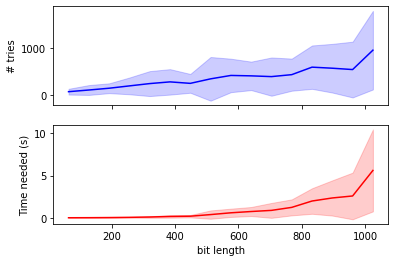

Total time: 421.83s


In [16]:
import matplotlib.pyplot as plt
T = 25

bit_lengths = list(range(64, 1025, 64))
tries = np.zeros([len(bit_lengths), T])
times = np.zeros([len(bit_lengths), T])

start = datetime.now()
# TODO: Iterate through the different bit lengths and create `T` primes.
#       For each one, record in `tries[b, t]` the number of tries it took
#       and in `times[b, t]` the amount of time it takes.
for b, bit_length in enumerate(bit_lengths):
    for t in range(T):
        start_time = datetime.now()
        _, num_tries = generate_prime(bit_length)
        end_time = datetime.now()

        tries[b, t] = num_tries
        times[b, t] = (end_time - start_time).total_seconds()

    print(f'Producing {T} {bit_length:4d}-bit length primes...')

tries_mean = tries.mean(axis=1)
tries_std = tries.std(axis=1)
times_mean = times.mean(axis=1)
times_std = times.std(axis=1)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(bit_lengths, tries_mean, 'b-', label='# tries')
ax1.fill_between(bit_lengths, tries_mean - tries_std, tries_mean + tries_std, color='b', alpha=0.2)
ax1.set_ylabel('# tries')

ax2.plot(bit_lengths, times_mean, 'r-', label='Time (s)')
ax2.fill_between(bit_lengths, times_mean - times_std, times_mean + times_std, color='r', alpha=0.2)
ax2.set_ylabel('Time needed (s)')
ax2.set_xlabel('bit length')
plt.show()
print(f'Total time: {(datetime.now() - start).total_seconds():6.2f}s')

## Implementing RSA

In this section you will implement the RSA cryptosystem as a Python class using the code you have already written. You may want to refer to https://en.wikipedia.org/wiki/RSA_(cryptosystem)#Operation

In [17]:
from math import gcd
from typing import Tuple

class RSA():
    """RSA implementation

    """
    def __init__(self, key_length: int) -> None:
        """Initialiation function

        Parameters
        ----------
        key_length : int
            Length of primes used to create an RSA key in bits.

        Returns:
        --------
        """
        self.key_length = key_length
        self._n = None
        self._e = None
        self._d = None

    def create_key(self) -> None:
        """Create key

        Creates new key by finding two primes of bit length `self.key_length`.
        n is defined as n = p * q.
        lambda(n) = lcm(p - 1, q - 1) = (p-1) * (q-1) / (gcd(p-1, q-1))
        Choose self._e to be a power of 2 incremented by 1.
        self._e must be less than lambda and coprime.
        Finally, self._d is the modular inverse of self._e with respect to lambda.
        - hint: use `pow()` with its 3rd argument to find the inverse.

        Parameters
        ----------

        Returns
        -------

        Raises
        ------
        ValueError
            If any part of the key is already set.
        """
        if (self._e is not None) or (self._d is not None) or (self._n is not None):
            ValueError('Parts of the key already set. Create a new instance.')
        # TODO: Fill in the function.
        p = generate_prime(self.key_length)[0]
        q = generate_prime(self.key_length)[0]
        self._n = p * q
        lambda_n = (p-1) * (q-1) // (gcd(p-1, q-1))
        i = 1
        while True:
            e = pow(2, i) + 1
            if math.gcd(e, lambda_n) == 1 and e < lambda_n:
                self._e = e
                break
            i += 1
        self._d = pow(self._e, -1, lambda_n)

    def set_public_key(self, e: int, n: int) -> None:
        """Set Public Key

        Sets the public key for encrypting with other people's public keys.

        Parameters
        ----------
        e : int
            Exponent used to encrypt messages.
        n : int
            Modulo used for encryption and decryption.

        Returns
        -------

        Raises
        ------
        ValueError
            If the public key is already set.
        """
        if (self._e is not None) or (self._n is not None):
            raise ValueError('Private key is already set. Create a new instance.')
        self._e = e
        self._n = n

    def set_private_key(self, d: int, n: int) -> None:
        """Set Public Key

        Sets the public key for encrypting with other people's public keys.

        Parameters
        ----------
        d : int
            Exponent used to decrypt messages.
        n : int
            Modulo used for encryption and decryption.

        Returns
        -------

        Raises
        ------
        ValueError
            If the public key is already set.
        """
        if (self._d is not None) or (self._n is not None):
            raise ValueError('Private key is already set. Create a new instance.')
        self._d = d
        self._n = n

    def get_public_key(self) -> Tuple[int, int]:
        """Get Public Key

        Returns the public key (e, n)

        Parameters
        ----------

        Returns
        -------
        e : int
            Exponent used to encrypt messages.
        n : int
            Modulo used for encryption and decryption.

        Raises
        ------
        ValueError
            If there is no public key set, raises an error
        """
        if (self._e is None) or (self._n is None):
            raise ValueError('No public key set.')
        return self._e, self._n

    def encrypt(self, message: int) -> int:
        """Encrypt

        Given an integer less than `self._n` it returns its RSA encryption.

        Parameters
        ----------
        message : int
            Message to be encrypted.

        Returns
        -------
        encrypted_message : int
            Encrypted message.

        Raises
        ------
        ValueError
            If the public key is not set.
        """
        if (self._e is None) or (self._n is None):
            raise ValueError('No public key set.')
        # TODO: Use the private key to encrypt the message.
        encrypted_message = pow(message, self._e, self._n)
        return encrypted_message

    def decrypt(self, encrypted_message: int) -> int:
        """Decrypt

        Given an encrypted messsages, recovers the original message

        Parameters
        ----------
        encrypted_message : int
            Message to be decrypted.

        Returns
        -------
        message : int
            Decrypted message

        Raises
        ------
        ValueError
            If the private key is not set.
        """
        if (self._d is None) or (self._n is None):
            raise ValueError('No private key set.')
        # TODO: Use the private key to decrypt the encrypted message
        message = pow(encrypted_message, self._d, self._n)
        return message

    def encrypt_bytes(self, message: bytes) -> bytes:
        """Encrypt bytes

        Given a sequence of bytes, breaks it up into groups,
        encrypts each group and returns the result as bytes.

        Parameters
        ----------
        message : bytes
            Text to be encrypted.

        Returns
        -------
        encrypted_message : bytes
            The encrypted  bytes concatenated.

        Raises
        ------
        ValueError
            If the public key is not set
        """
        if (self._e is None) or (self._n is None):
            raise ValueError('No public key set.')
        # TODO: Break up the message into groups such that they fit in `key_length`.
        #       If the message is not an integer multiple of `key_length`, append the zero byte at the end.
        #       Remember that a byte is 8 bits.
        #       Turn each group into an integer, encrypt it and turn it back into bytes of size `2 * key_length`.
        #       Concatenate all bytes together in a bytearray and return it as bytes.
        #       Use little endian.

        # Consider using the `int.from_bytes()` and `int.to_bytes()` functions for conversions. They are more powerful than they
        # look, so check out the documentation.
        encrypted_bytes = bytearray(b'')
        byte_length = self.key_length // 8
        for i in range(0, len(message), byte_length):
            block = message[i:i + byte_length]
            block_int = int.from_bytes(block, byteorder='little')
            encrypted_block = pow(block_int, self._e, self._n)
            encrypted_bytes.extend(encrypted_block.to_bytes(2 * byte_length, byteorder='little'))

        return bytes(encrypted_bytes)

    def decrypt_bytes(self, encrypted_message: bytes) -> bytes:
        """Decrypt bytes

        Given a sequence of bytes, breaks it up into groups,
        decrypts each group and returns the result as bytes.

        Parameters
        ----------
        encrypted_message : bytes
            Text to be decrypted.

        Returns
        -------
        message : bytes
            The decrypted  bytes concatenated.

        Raises
        ------
        ValueError
            If the private key is not set
        """
        if (self._d is None) or (self._n is None):
            raise ValueError('No private key set.')
        # TODO: Break up the encrypted_message into groups such that they fit in `2 * key_length`.
        #       Turn each group into an integer, decrypt it and turn it back into bytes of `key_length`.
        #       Concatenate all bytes together.
        #       Use little endian.

        # Consider using the `int.from_bytes()` and `int.to_bytes()` functions for conversions. They are more powerful than they
        # look, so check out the documentation.
        message = bytearray(b'')
        byte_length = self.key_length // 8
        block_length = byte_length * 2
        for i in range(0, len(encrypted_message), block_length):
            block = encrypted_message[i:i + block_length]
            block_int = int.from_bytes(block, byteorder='little')
            decrypted_block = pow(block_int, self._d, self._n)
            message.extend(decrypted_block.to_bytes(byte_length, byteorder='little'))
        return bytes(message)


cipher = RSA(128)
cipher.create_key()

# Test key generation.
for i in range(10):
    a = random.randint(2, int(math.sqrt(cipher._n)))
    new_a = pow(pow(a, cipher._e, cipher._n), cipher._d, cipher._n)
    assert new_a == a, f"Key generation malfunctions. m = {a} ((m^e)^d) % n = {new_a}"

# Test encryption and decryption of a single block
for i in range(10):
    a = random.randint(2, int(math.sqrt(cipher._n)))
    encrypt_decrypt_a = cipher.decrypt(cipher.encrypt(a))
    decrypt_encrypt_a = cipher.encrypt(cipher.decrypt(a))
    assert encrypt_decrypt_a == a, "Decryption of encrypted integer failed."
    assert encrypt_decrypt_a == a, "Reencryption of decrypted integer failed."

# Test encryption and decryption of a larger bytestring
msg = bytes("RSA (Rivest-Shamir-Adleman) is a public-key cryptosystem, one of the oldest widely used for secure data transmission.", encoding='utf-8')
print(f'message:\n    {msg}')
ctxt = cipher.encrypt_bytes(msg)
print(f'ciphertext:\n    {ctxt}')
msg_decrypted = cipher.decrypt_bytes(ctxt)
print(f'decrypted message:\n    {msg_decrypted}')  # There may be additional 0 bytes at the end (written \x00). This is fine.
assert(msg == msg_decrypted[:len(msg)])

message:
    b'RSA (Rivest-Shamir-Adleman) is a public-key cryptosystem, one of the oldest widely used for secure data transmission.'
ciphertext:
    b"\x17]&q\xd5\x8da=\x9a\x88`\xbb\x9c~\xefA\x15\x93\xee\x05o\xd3\x99H\xedG\xe4F\xa1\\\xca \x82d\xb1\xcf\xca\xc3-\xbf\xdc\xaf\x04\xd5\xf6ik\xbb\x92\xd0\xf9\xe1\x1a2\xa8\x8fO\x9f\xf6f\x90\x9a\xcc+\xf1\x85\xd3n\x01\xd1[u\xa5H\xec\xad:5K\xf1j\xc6W\xc9JK\xcb\xff\x98\x19\x16\xa4\xe9Z\x86v\x8c\xafv\x12\x0f\xa3\xcco\x93\xed^\x89\xaa,`fs\xccL<\x86-s\x99\x07\x86\x0f?\x85\t)\x17\x1f\xea\xa6\xf9\xf5\xae\xe5\x16y]\xf0\x01J\x04\xe8(\xb6\xfa\x85l\xec\xb3\x9cdX\x8b\x82\x91\xe10\x8cC\xa2\xd8\xab8\x99\x07>\x17\xde\x83\xc0\x92\xf2T\n\x93\\R5I\xcf\xec]:\xec\x877,\n\x12\xa8LB\x8ebv-\xfcwM\xcd8\x83\x19\xf1p}C\xd7\xb9\x96\xe94\x05\xcb\xaa\xdc\xd1\xd0\xdf\x17\x0f\xfc.\xeb'f-\x01\xca\xa0\x1b\xe1\xe0\x965\x04\x87\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00"
decrypted message:
    b'RSA (Rivest-Shamir-Adleman) is a public-key cryptosystem

## Decrypting your own cryptogram

For each one of you we have created a cryptogram. Your cryptogram, your private key (the number `d`), and your public key (`e` and `n`) have been sent to you in an email. **Let us know on Slack if you cannot find this email.** Decrypt your assigned cryptogram and print it below.

In [18]:
import base64

key_length = 128
# TODO: Paste your cryprtogram, public key and student ID below
b64_encrypted_message = "AOGWi4NzmEevY9VNp294yC62LA3cUovEg5489QewbQeAiPv8ayPSSGziSf4Hu88OWdLxJMKMq4DOQPfnUXIVq0XkZJKUNyd/mF1J1dkjZE7BReqJuKSczWOKGlv+p7Gb"
n = 78591298842346353817823717406009583667053372946398721242840366228533006009907
d = 30833314853318549984483866633257334636707564253190972202669093919817679227553
# Note that e is not necessary for decrpytion.

cipher = RSA(key_length)
cipher.set_private_key(d, n)
encrypted_message = base64.b64decode(b64_encrypted_message)

message = cipher.decrypt_bytes(encrypted_message)
print(message.decode())

So long, and thanks for all the fish.           


### Food for thought (you do **not** need to answer these questions)
- Originally, we wanted your private key in the above cell to be your student id. This didn't really work, since some of the ids were even, and we could not choose a public key corresponding to an even private key. Do you see why?
- It is often advised that programmers never implement their own cryptography functions, since it is very easy to make a mistake and write an insecure algorithm. Even if you implemented the code above perfectly, there is still an issue with our design, which lets an adversary learn some information about the message corresponding to some cryptogram, even if they cannot fully decrypt it. Can you spot this issue?
  - If you are interested, you can read more about this issue [here](https://words.filippo.io/the-ecb-penguin/) .
- Another potential issue with the algorithm involves the choice of primes. Your
  code (likely) uses pythons standard random number generation functions. These functions are deterministic, and based on a seed, which is usually the system time when the first random call is made. How might an attacker use this to break the security of RSA. How might we strengthen the system against such attacks?
